# 0. Imports and settings

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Lambda, Convolution2D, MaxPooling2D
from skimage import data, color, exposure
from skimage.io import imread
from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


In [2]:
IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS = 64, 64, 3

DATA_DIR = 'data/'
LOG_DIR = 'log/'
MODELS_DIR = 'models/'
MODEL_NAME = 'cnn_cars'

# 1. Data loading

In [3]:
def print_info(x, y):
    unique, counts = np.unique(y, return_counts=True)
    print('x: {} {} \t y: {} {} \t counts: {}'.format(x.shape, x.dtype, y.shape, y.dtype, dict(zip(unique, counts))))

def get_samples(x, y, class_label, n_samples=10):
    mask = np.where(y == class_label)[0][:n_samples]
    return x[mask], y[mask]

def plot_batch(img_batch, y_true, y_pred=None, n_cols=10):
    plt.figure(figsize=(16,5))
    
    y_pred = y_true if y_pred is None else y_pred    
    n_rows = img_batch.shape[0] // n_cols + 1
    for img, true, pred, sub in zip(img_batch, y_true, y_pred, range(1, len(img_batch)+1)):
        plt.subplot(n_rows, n_cols, sub)
        plt.imshow(img.astype(np.uint8))
        
        title = "{}:{:.2f}".format("car" if pred > 0 else "non-car", pred)
        pred = np.where(pred > 0, 1, -1)
        c = 'green' if true == pred else 'red'
        
        plt.title(title, color = c)
        plt.axis('off')
    plt.tight_layout()

In [4]:
cars = glob(DATA_DIR+'vehicles/*/*.png')
non_cars = glob(DATA_DIR+'non-vehicles/*/*.png')

y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))-1])

x = []
for file in cars:
    x.append(imread(file))
    
for file in non_cars:
    x.append(imread(file))
    
x = np.array(x)

print_info(x, y)

x: (17760, 64, 64, 3) uint8 	 y: (17760,) float64 	 counts: {-1.0: 8968, 1.0: 8792}


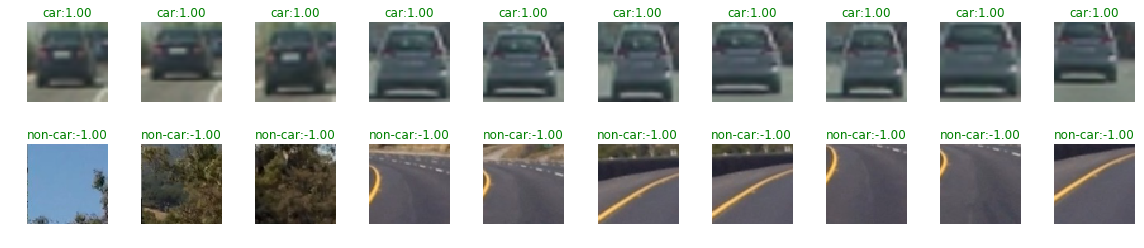

In [5]:
car_samples, car_labels = get_samples(x, y, class_label=1)
noncar_samples, noncar_labels = get_samples(x, y, class_label=-1)

samples = np.vstack((car_samples, noncar_samples))
labels = np.concatenate((car_labels, noncar_labels))
plot_batch(samples, labels)

In [6]:
# Split the dataset into training, validation, and testing
x_train, x_test, y_train, y_test = train_test_split(x.astype(np.float32), y.astype(np.float32), test_size=0.1, stratify=y, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=x_test.shape[0], stratify=y_train, random_state=42)

print_info(x_train, y_train)
print_info(x_val, y_val)
print_info(x_test, y_test)

x: (14208, 64, 64, 3) float32 	 y: (14208,) float32 	 counts: {-1.0: 7174, 1.0: 7034}
x: (1776, 64, 64, 3) float32 	 y: (1776,) float32 	 counts: {-1.0: 897, 1.0: 879}
x: (1776, 64, 64, 3) float32 	 y: (1776,) float32 	 counts: {-1.0: 897, 1.0: 879}


# 2. Graph Constrution

In [7]:
def get_conv(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), filename=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.0, input_shape=input_shape, output_shape=input_shape))
    model.add(Convolution2D(filters=10, kernel_size=[3,3], activation='relu', name='conv1', input_shape=input_shape, padding='same'))
    model.add(Convolution2D(filters=10, kernel_size=[3,3], activation='relu', name='conv2', padding='same'))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(rate=0.25))
    model.add(Convolution2D(filters=128, kernel_size=[8,8], activation='relu', name='dense1'))
    model.add(Dropout(rate=0.5))
    model.add(Convolution2D(filters=1, kernel_size=[1,1], activation='tanh', name='dense2'))
    if filename:
        model.load_weights(filename)        
    return model

# 3. Training and Evaluation 

In [8]:
model = get_conv()
model.add(Flatten())
model.compile(loss='mse', optimizer='adadelta', metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=128, epochs=5, verbose=1, validation_data=(x_val, y_val))
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss: {} accuracy: {:.2f}%".format(score[0], score[1]*100))
model.save_weights(MODELS_DIR+MODEL_NAME)

Train on 14208 samples, validate on 1776 samples
Epoch 1/5
14208/14208 [==============================] - 50s - loss: 0.5353 - acc: 0.4786 - val_loss: 0.2319 - val_acc: 0.7967
Epoch 2/5
14208/14208 [==============================] - 50s - loss: 0.2135 - acc: 0.8283 - val_loss: 0.1413 - val_acc: 0.8936
Epoch 3/5
14208/14208 [==============================] - 50s - loss: 0.1218 - acc: 0.9025 - val_loss: 0.0959 - val_acc: 0.9274
Epoch 4/5
14208/14208 [==============================] - 49s - loss: 0.0881 - acc: 0.9288 - val_loss: 0.0899 - val_acc: 0.9364
Epoch 5/5
14208/14208 [==============================] - 49s - loss: 0.0765 - acc: 0.9425 - val_loss: 0.0707 - val_acc: 0.9505
Test loss: 0.05419095419347286 accuracy: 95.66%


# 4. Restore and Testing 

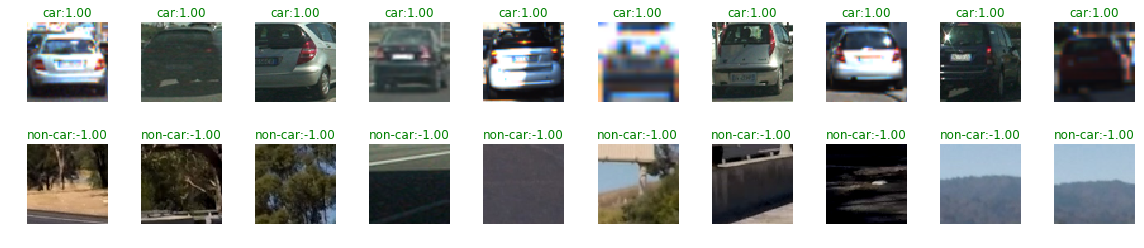

In [9]:
car_test, car_labels = get_samples(x_test, y_test, class_label=1)
noncar_test, noncar_labels = get_samples(x_test, y_test, class_label=-1)

test_batch = np.vstack((car_test, noncar_test))
test_labels = np.concatenate((car_labels, noncar_labels))

plot_batch(test_batch, test_labels, test_labels)

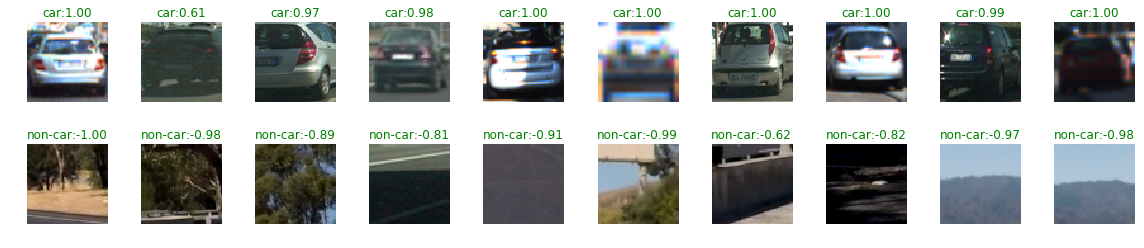

In [10]:
model = get_conv(filename=MODELS_DIR+MODEL_NAME)
model.add(Flatten())
model.compile(loss='mse', optimizer='adadelta', metrics=['accuracy'])

test_pred = model.predict(test_batch)
plot_batch(test_batch, test_labels, test_pred.ravel())

# 5. References

- [Original Article](https://medium.com/@tuennermann/convolutional-neural-networks-to-find-cars-43cbc4fb713)
- [Original Code (in Keras)](https://github.com/HTuennermann/Vehicle-Detection-and-Tracking)
- [Vehicle Dataset](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [Non-Vehicle Dataset](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip)